## Analysis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Impact Of Airline Tweets in the Sentiment Of A Conversation

Dataset of conversations & Dates as downloaded here
https://drive.google.com/open?id=13v22L7LXIElILm2M4vfdfeo9sMjyqIOM

In [50]:
df = pd.read_csv('conversations_with_sentimpact.csv', encoding='ISO-8859-1')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
df['mean_sentiment'].astype(float, inplace=True).describe()

count    372429.000000
mean          0.542905
std           0.584006
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           2.000000
Name: mean_sentiment, dtype: float64

In [52]:
df.head()

,Unnamed: 0,Unnamed: 0.1,False,conversation_id,raw_tweets_info,conversation_length,tweet_ids,user_ids,airlines_involved,mean_sentiment,sentiments,full_text,dates,SentChange
0,0,0,0,5,"[(747530773037780992, 31132554), (747526794446...",2,"[747526794446802944, 747530773037780992]","[22873368, 31132554]",['No airlines involved'],NaN,"[nan, 1]",['Hey @British_Airways our @easyJet flight Ven...,"['Mon Jun 27 20:27:30 +0000 2016', 'Mon Jun 27...",[]
1,1,1,1,6,"[(747530681509625860, 417945325), (74745123859...",2,"[747451238598475776, 747530681509625860]","[55904765, 417945325]",['No airlines involved'],0.0,"[0, 0]",['@easyJet thanks for looking after my luggage...,"['Mon Jun 27 15:27:16 +0000 2016', 'Mon Jun 27...",[]
2,2,2,2,11,"[(747530531475173376, 597673831), (74752831114...",2,"[747528311144734720, 747530531475173376]","[427951650, 597673831]",['No airlines involved'],0.5,"[1, 0]","[""@British_Airways I booked via Expedia. I'm n...","['Mon Jun 27 20:33:32 +0000 2016', 'Mon Jun 27...",[]
3,3,3,3,12,"[(747530509098450944, 1624311463), (7475297117...",2,"[747529711782244352, 747530509098450944]","[1624311463, 1624311463]",['No airlines involved'],0.0,"[0, 0]",['@easyJet is there anyway to travel with 2 ca...,"['Mon Jun 27 20:39:06 +0000 2016', 'Mon Jun 27...",[]
4,4,4,4,14,"[(747530348561571840, 154605692), (74752081839...",2,"[747520818398232576, 747530348561571840]","[117754884, 154605692]",['No airlines involved'],0.5,"[1, 0]",['@easyJet how nice of you not to reply to my ...,"['Mon Jun 27 20:03:46 +0000 2016', 'Mon Jun 27...",[]


## User sentiment before and after customer support

In [53]:
#helper functions
def append_row(df, entry):
    assert len(df.columns) == len(entry), "Not enough data"
    df2 = pd.DataFrame([entry,], columns=df.columns)
    return df.append(df2, ignore_index=True)

def time_delta(datestring1, datestring2):
    date1 = datetime.datetime.strptime(datestring1, '%a %b %d %H:%M:%S +0000 %Y')
    date2 = datetime.datetime.strptime(datestring2, '%a %b %d %H:%M:%S +0000 %Y')
    timedelta = date2 - date1
    return(timedelta.seconds)

In [54]:
def sentiment_vs_replytime(airline, airline_id, df):
    total = 0
    errors = 0
    
    #filter on specific airline
    if len(airline) == 1:
        df_airline = df[df['airlines_involved'] == f"['{airline[0]}']"]
        print(f"[{airline[0]}]")
        print(df_airline.shape)
    else:
        df_airline = df
    
    df_airline = df_airline[df_airline.astype(str)['SentChange'] != '[]']
    
    df_interaction = pd.DataFrame(columns=['replyTime', 'sentChange'])
    #find interactions
    for data in df_airline[['user_ids', 'sentiments', 'dates', 'SentChange']].values:
        all_ids = eval(data[0])
        sentchange = eval(data[3])
        #sent_change_count = 0
        for i in range(0, len(all_ids)):
            if (str(all_ids[i]) in airline_id) and (len(sentchange)!=0):   
                    try:
                        total += 1
                        date1 = eval(data[2])[i-1]
                        date2 = eval(data[2])[i]
                        replytime = time_delta(date1, date2)

                        sentiment_delta = sentchange[0]
                        del sentchange[0]

                        df_interaction = append_row(df_interaction, [replytime, sentiment_delta])
                    except NameError:
                        errors += 1
                        pass
    
    print('errors: ' + str(errors))
    print('total: ' + str(total))
    return df_interaction

In [55]:
df_klm1 = sentiment_vs_replytime(["KLM"],["56377143"], df)
#df_klm1['replyTime'].describe()
df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')
df_klm1['sentChange'] = df_klm1['sentChange'].astype('float64')

[KLM]
(37868, 14)
errors: 0
total: 2373


In [56]:
df_ba1 = sentiment_vs_replytime(["British_Airways"],["18332190"], df)
#df_klm1['replyTime'].describe()
df_ba1.shape

[British_Airways]
(68941, 14)
errors: 0
total: 10088


(10088, 2)

# Statistical Analysis

In [36]:
from sklearn.linear_model import LinearRegression  # for linear regression

In [38]:
lr = LinearRegression()
lr.fit(df_klm1[['replyTime']], df_klm1[['sentChange']])
lr.coef_[0][0], lr.intercept_

(-1.1775573970540603e-06, array([-0.2539454]))

In [19]:
lr2 = LinearRegression()
lr2.fit(df_ba1[['replyTime']], df_ba1[['sentChange']])
lr2.coef_, lr2.intercept_

(array([[  5.04457572e-10]]), array([-0.23780377]))

# Visualization

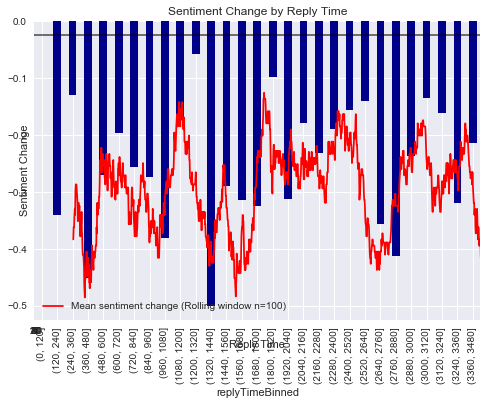

In [48]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')
df_klm1['sentChange'] = df_klm1['sentChange'].astype('float64')
bins = [120*n for n in range(0, 30)]
df_klm1['replyTimeBinned'] = pd.cut(df_klm1['replyTime'], bins)
klm_grouped = df_klm1.groupby(by='replyTimeBinned')


df_klm2 = df_klm1.sort_values(by='replyTime', ascending=True).rolling(100).mean()
df_klm2 = df_klm2.set_index('replyTime')

df_klm2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)', ax=ax2, grid=False)
klm_grouped['sentChange'].mean().plot(kind='bar', color='darkblue',label='Mean Sentiment Change per ReplyTime', ax=ax)

plt.xticks([])
plt.yticks([])

plt.xlim(0,3600)
plt.xticks([5*n for n in range(0, 6)],[10*n for n in range(0, 6)])
plt.ylabel('Sentiment Change')
plt.xlabel('Reply Time')
plt.title("Sentiment Change by Reply Time")
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower left')
#klm_grouped['sentChange'].count().plot(kind='bar')
plt.show()

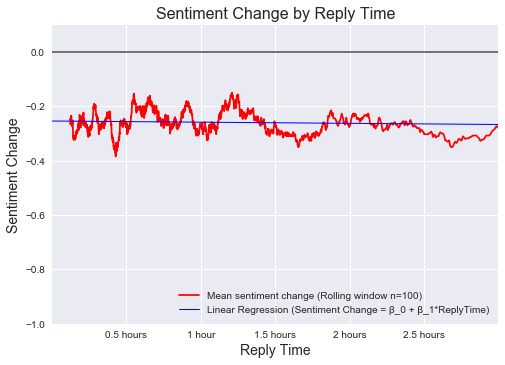

In [47]:
df_klm2 = df_klm1.sort_values(by='replyTime', ascending=True).rolling(200).mean()
df_klm2 = df_klm2.set_index('replyTime')

df_klm2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)')

lr = LinearRegression()
lr.fit(df_klm1[['replyTime']], df_klm1[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
plt.plot([x1, x2], [y1, y2], 'k-', lw=1, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='blue')

plt.xlim(0,10800)
plt.ylim(-1,0.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.png', dpi=300)
plt.show()

In [147]:
airline_names = ["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"]
airline_ids = ["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]

df_all = sentiment_vs_replytime(airline_names, airline_ids, df)
df_all['replyTime'].describe()

errors: 8974
total: 75605


count     66631
unique    15418
top         124
freq         68
Name: replyTime, dtype: int64

# Luggage Classifier